# Agentic RAG with Tool Use

Tool use allows for greater flexibility in accessing and utilizing data sources, thus unlocking new use cases not possible with a standard RAG approach.

In an enterprise setting where data sources are diverse with non-homogeneous formats (structured/semi-structured/unstructured), this approach becomes even more important.

In this notebook, we'll look at how we can implement an agentic RAG system using a tool use approach. We'll do this by building a Weights & Biases assistant. The assistant can search for information about how to use the product, retrieve information from the internet, search code examples, and even perform data analysis.

Concretely, we'll cover the following use cases:
1. Tool routing
2. Parallel tool use
3. Multi-step tool use
4. Self-correction
5. Structured queries
6. Structured data queries
7. Action (plotting charts)

We'll give the assistant access to the following tools:
- `search_developer_docs`: Searches the Weights & Biases developer documentation
- `search_internet`: Searches the internet for general queries
- `search_code_examples`: Searches code examples and tutorials on using Weights & Biases
- `analyze_evaluation_results`: Analyzes a table containing results from evaluating an LLM application

Note that for simplicity, we are not implementing a full-fledge search. Instead, we'll use a mock datasets containing small, pre-defined data for each tool.

# Setup

In [ ]:
# ! pip install -U cohere pandas -q

In [2]:
import json
import os
from typing import Dict, List, Optional

import cohere

from tool_def_v2 import (
    search_developer_docs,
    search_internet,
    search_code_examples,
    analyze_evaluation_results,
    tools,
)

co = cohere.ClientV2(api_key=os.environ["COHERE_API_KEY"])

In [4]:
functions_map = {
    "search_developer_docs": search_developer_docs,
    "search_internet": search_internet,
    "search_code_examples": search_code_examples,
    "analyze_evaluation_results": analyze_evaluation_results
}

In [5]:
system_message="""## Task and Context
You are an assistant who helps developers use Weights & Biases. The company is also referred to as Wandb or W&B for short. You are equipped with a number of tools that can provide different types of information. If you can't find the information you need from one tool, you should try other tools if there is a possibility that they could provide the information you need. Use the internet to search for information not available in the sources provided by Weights & Biases"""

# Function to run the agent

In [28]:
def run_agent(query: str, messages: list[dict] | None = None) -> List[Dict[str, str]]:
    """
    Run the agent with the given query and messages.
    """
    if messages is None:
        messages = []

    if 'system' not in {m.get('role') for m in messages}:
        messages = [{'role': 'system', 'content': system_message}]
    
    # Step 1: get user message
    print(f"USER MESSAGE:\n{query}")
    print("="*50)
    
    messages.append({'role': 'user','content': query})

    # 2 - Model generates tool calls, if any
    model = "command-r-plus-08-2024"
    res = co.chat(model=model,
                messages=messages,
                tools=tools,
                temperature=0.2)
    
    # Keep invoking tools as long as the model generates tool calls
    while res.message.tool_calls:
        # Tool plan and tool calls
        print("\nTOOL PLAN:")
        print(res.message.tool_plan)
        
        print("\nTOOL CALLS:")
        for tc in res.message.tool_calls:
            print(f"Tool name: {tc.function.name} | Parameters: {tc.function.arguments}")
        
        messages.append({'role': 'assistant',
                        'tool_calls': res.message.tool_calls,
                        'tool_plan': res.message.tool_plan})
        
        # 3 - Execute tools based on the tool calls generated by the model
        print("\nTOOL RESULTS:")
        for tc in res.message.tool_calls:
            tool_result = functions_map[tc.function.name](**json.loads(tc.function.arguments))
            tool_content = [json.dumps(tool_result)]
            print(tool_result, "\n")
            
            messages.append({'role': 'tool',
                            'tool_call_id': tc.id,
                            'tool_content': tool_content}) 
        
        # 4 - Model either generates more tool calls or returns a response
        res = co.chat(model=model,
                    messages=messages,
                    tools=tools,
                    temperature=0.2)
        
    print("\nRESPONSE:")
    print(res.message.content[0].text)

    if res.message.citations:
        print("\nCITATIONS:")
        for citation in res.message.citations:
            print(f"Start: {citation.start} | End: {citation.end} | Text: '{citation.text}'")
            print("Sources:")
            if citation.sources:
                for source in citation.sources:
                    print(source.id)
            print("-"*50)
    
    return messages

# 1: Tool routing

With tool routing, the agent decides which tool(s) to use based on the user's query.

In [11]:
messages = run_agent("Where can I find the output of a run")

USER MESSAGE:
Where can I find the output of a run

TOOL PLAN:
I will search for "Where can I find the output of a run?"

TOOL CALLS:
Tool name: search_developer_docs | Parameters: {"query":"Where can I find the output of a run?"}

TOOL RESULTS:
{'developer_docs': [{'text': 'What is a W&B Run?\nA W&B run is a single unit of computation logged by W&B, representing an atomic element of your project.'}, {'text': "How do I view a specific run?\nTo view a run, navigate to the W&B App UI, select the relevant project, and then choose the run from the 'Runs' table."}, {'text': 'What are Artifact Outputs?\nArtifact Outputs refer to any artifacts produced by a run.'}, {'text': 'How can I do hyperparameter search quickly?\nUse W&B Sweeps to automate hyperparameter search and visualize rich, interactive experiment tracking.'}]} 


RESPONSE:
You can find the output of a run by navigating to the W&B App UI, selecting the relevant project, and then choosing the run from the 'Runs' table.

CITATIONS:


In [12]:
messages = run_agent("How much storage does the Wandb teams pricing offer?")

USER MESSAGE:
How much storage does the Wandb teams pricing offer?

TOOL PLAN:
I will search for "Wandb teams pricing storage".

TOOL CALLS:
Tool name: search_internet | Parameters: {"query":"Wandb teams pricing storage"}

TOOL RESULTS:
{'documents': [{'url': 'https://wandb.ai/site/pricing', 'content': 'The free academic license comes with all the product features included on Teams, 100GB of storage, unlimited tracked hours, and up to 100 seats. Additional storage can be purchased for $0.03 per GB, billed monthly. Weights & Biases MLOps and LLMOps pricing plans. Always free for academics.'}, {'url': 'https://docs.wandb.ai/guides/app/settings-page/team-settings', 'content': 'The Usage section describes the total memory usage the team has consumed on the Weights and Biases servers. The default storage plan is 100GB. For more information about storage and pricing, see the Pricing page. Storage The Storage section describes the'}, {'url': 'https://docs.wandb.ai/guides/app/features/teams', 

# 2: Parallel tool use

The agent can call multiple tools in parallel. In this example, given that the user is asking about two different things in a single message, the agent generates two parallel tool calls.

In [17]:
messages = run_agent("Explain what is a W&B Run and how do I view a specific run")

USER MESSAGE:
Explain what is a W&B Run and how do I view a specific run

TOOL PLAN:
I will search for "what is a W&B Run" and "how to view a specific run" in the Weights & Biases developer documentation.

TOOL CALLS:
Tool name: search_developer_docs | Parameters: {"query":"what is a W\u0026B Run"}
Tool name: search_developer_docs | Parameters: {"query":"how to view a specific run"}

TOOL RESULTS:
{'developer_docs': [{'text': 'What is a W&B Run?\nA W&B run is a single unit of computation logged by W&B, representing an atomic element of your project.'}, {'text': "How do I view a specific run?\nTo view a run, navigate to the W&B App UI, select the relevant project, and then choose the run from the 'Runs' table."}, {'text': 'What are Artifact Outputs?\nArtifact Outputs refer to any artifacts produced by a run.'}, {'text': 'How can I do hyperparameter search quickly?\nUse W&B Sweeps to automate hyperparameter search and visualize rich, interactive experiment tracking.'}]} 

{'developer_doc

# 3: Multi-step tool use

There will be scenarios where tool calling needs to happen in a sequence. For example, when the output of one tool call is needed as input for another tool call.

In this example, the agent first searches the developer docs for information about how to view a run. Then, it uses the information to search for a code example.

In [22]:
messages = run_agent("What's that feature to view artifacts? Do you have any jupyter notebook examples?")

USER MESSAGE:
What's that feature to view artifacts? Do you have any jupyter notebook examples?

TOOL PLAN:
I will search for the feature to view artifacts. If I find it, I will search for a Jupyter notebook example.

TOOL CALLS:
Tool name: search_developer_docs | Parameters: {"query":"view artifacts"}

TOOL RESULTS:
{'developer_docs': [{'text': 'What is a W&B Run?\nA W&B run is a single unit of computation logged by W&B, representing an atomic element of your project.'}, {'text': "How do I view a specific run?\nTo view a run, navigate to the W&B App UI, select the relevant project, and then choose the run from the 'Runs' table."}, {'text': 'What are Artifact Outputs?\nArtifact Outputs refer to any artifacts produced by a run.'}, {'text': 'How can I do hyperparameter search quickly?\nUse W&B Sweeps to automate hyperparameter search and visualize rich, interactive experiment tracking.'}]} 


TOOL PLAN:
I found that Artifact Outputs refer to any artifacts produced by a run. I will now se

# 4: Self-correction

The concept of multi-step tool use can be extended to self-correction. Given the output of the current tool call, the agent may decide to change its plan i.e. self-correct. 

In this example, the agent doesn't find the information it's looking for in the developer docs. Thus, it generates a new tool call to search the internet.

In [23]:
messages = run_agent("What is the weave product from wandb?")

USER MESSAGE:
What is the weave product from wandb?

TOOL PLAN:
I will search for 'weave product wandb' to find the answer to the question.

TOOL CALLS:
Tool name: search_developer_docs | Parameters: {"query":"weave product wandb"}

TOOL RESULTS:
{'developer_docs': [{'text': 'What is a W&B Run?\nA W&B run is a single unit of computation logged by W&B, representing an atomic element of your project.'}, {'text': "How do I view a specific run?\nTo view a run, navigate to the W&B App UI, select the relevant project, and then choose the run from the 'Runs' table."}, {'text': 'What are Artifact Outputs?\nArtifact Outputs refer to any artifacts produced by a run.'}, {'text': 'How can I do hyperparameter search quickly?\nUse W&B Sweeps to automate hyperparameter search and visualize rich, interactive experiment tracking.'}]} 


TOOL PLAN:
I couldn't find any information about the weave product from wandb in the developer documentation. I will now search the internet to see if I can find any in

# 5: Structured queries

The tool use setup can be leveraged to perform structured queries. For data sources that contain rich metadata, structured queries can be used to perform highly-specific queries, returning more accurate results.

In this example, we can take advantage of metadata available in the code examples dataset such as the file type and language.

In [24]:
messages = run_agent("Any jupyter notebook for Data Versioning with Artifacts?")
# Tool call: Searches search_code_examples with file_type = ipynb
# Answer: Returns file - Model/Data Versioning with Artifacts (PyTorch)

USER MESSAGE:
Any jupyter notebook for Data Versioning with Artifacts?

TOOL PLAN:
I will search for a Jupyter notebook for Data Versioning with Artifacts.

TOOL CALLS:
Tool name: search_code_examples | Parameters: {"file_type":"ipynb","language":"en","query":"Data Versioning with Artifacts"}

TOOL RESULTS:
{'code_examples': [{'content': 'Interactive W&B Charts Inside Jupyter', 'file_type': 'ipynb', 'language': 'en'}, {'content': 'Model/Data Versioning with Artifacts (PyTorch)', 'file_type': 'ipynb', 'language': 'en'}, {'content': 'Create a hyperparameter search with W&B PyTorch integration', 'file_type': 'ipynb', 'language': 'en'}, {'content': 'Get started with W&B Weave', 'file_type': 'ipynb', 'language': 'en'}]} 


RESPONSE:
Yes, there is a Jupyter notebook for Data Versioning with Artifacts (PyTorch).

CITATIONS:
Start: 16 | End: 77 | Text: 'Jupyter notebook for Data Versioning with Artifacts (PyTorch)'
Sources:
search_code_examples_5qb0cm7rp68f:0
----------------------------------

# 6: Structured data queries

The agent can generate queries against structured data sources, such as a CSV file or a database.

In this example, we'll use a mock dataset containing LLM application evaluation results for different use cases and settings. Since it's a CSV file, we can create the `analyze_evaluation_results` tool to perform queries on the dataset using the pandas library, executed by a Python interpreter.

In [34]:
messages = run_agent("What's the average evaluation score in run A")
# Answer: 0.63

USER MESSAGE:
What's the average evaluation score in run A

TOOL PLAN:
I will use the 'analyze_evaluation_results' tool to find the average evaluation score in run A.

TOOL CALLS:
Tool name: analyze_evaluation_results | Parameters: {"code":"import pandas as pd\n\ndf = pd.read_csv(\"evaluation_results.csv\")\n\n# Filter the dataframe to only include rows where the run is 'A'\nfiltered_df = df[df['run'] == 'A']\n\n# Calculate the average score\naverage_score = filtered_df['score'].mean()\n\nprint(f\"The average evaluation score in run A is {average_score}\")"}

TOOL RESULTS:
{'python_answer': 'The average evaluation score in run A is 0.6333333333333334\n'} 


RESPONSE:
The average evaluation score in run A is 0.6333333333333334.

CITATIONS:
Start: 41 | End: 60 | Text: '0.6333333333333334.'
Sources:
analyze_evaluation_results_smgt4k1grzcx:0
--------------------------------------------------


In [35]:
messages = run_agent("What's the latency of the highest-scoring run for the summarize_article use case?")
# Answer: 4.8

USER MESSAGE:
What's the latency of the highest-scoring run for the summarize_article use case?

TOOL PLAN:
I will use the 'analyze_evaluation_results' tool to find the latency of the highest-scoring run for the summarize_article use case.

TOOL CALLS:
Tool name: analyze_evaluation_results | Parameters: {"code":"import pandas as pd\n\ndf = pd.read_csv(\"evaluation_results.csv\")\n\n# Filter the dataframe to only include rows where the usecase is 'summarize_article'\nfiltered_df = df[df['usecase'] == 'summarize_article']\n\n# Find the highest-scoring run\nhighest_scoring_run = filtered_df.loc[filtered_df['score'].idxmax()]\n\n# Print the latency of the highest-scoring run\nprint(f\"The latency of the highest-scoring run for the summarize_article use case is {highest_scoring_run['latency']} seconds.\")"}

TOOL RESULTS:
{'python_answer': 'The latency of the highest-scoring run for the summarize_article use case is 4.8 seconds.\n'} 


RESPONSE:
The latency of the highest-scoring run for th

In [43]:
messages = run_agent("Which use case uses the least amount of tokens on average and what's the average token count?")
# Answer: extract_names (106.25)

USER MESSAGE:
Which use case uses the least amount of tokens on average and what's the average token count?

TOOL PLAN:
I will use the 'analyze_evaluation_results' tool to find out which use case uses the least amount of tokens on average and what the average token count is.

TOOL CALLS:
Tool name: analyze_evaluation_results | Parameters: {"code":"import pandas as pd\n\ndf = pd.read_csv(\"evaluation_results.csv\")\n\n# Calculate the average number of tokens for each use case\naverage_tokens_per_usecase = df.groupby(\"usecase\")[\"tokens\"].mean()\n\n# Find the use case with the lowest average number of tokens\nmin_tokens_usecase = average_tokens_per_usecase.idxmin()\nmin_tokens_usecase_avg = average_tokens_per_usecase.min()\n\nprint(f\"Use case with the least average number of tokens: {min_tokens_usecase}\")\nprint(f\"Average number of tokens for that use case: {min_tokens_usecase_avg}\")"}

TOOL RESULTS:
{'python_answer': 'Use case with the least average number of tokens: extract_name

# 7. Action (plotting charts)

Since we have access to the Python interpreter, we can also use it to perform other tasks such as plotting charts.

USER MESSAGE:
Create a plot of the average evaluation score for each temperature setting for the extract_names use case.

TOOL PLAN:
I will use the 'analyze_evaluation_results' tool to create a plot of the average evaluation score for each temperature setting for the extract_names use case.

TOOL CALLS:
Tool name: analyze_evaluation_results | Parameters: {"code":"import pandas as pd\n\ndf = pd.read_csv(\"evaluation_results.csv\")\n\n# Filter the dataframe to only include the extract_names use case\ndf = df[df[\"usecase\"] == \"extract_names\"]\n\n# Group by temperature and calculate the average score\navg_score_by_temp = df.groupby(\"temperature\")[\"score\"].mean()\n\n# Plot the average score by temperature\navg_score_by_temp.plot(kind=\"bar\")"}

TOOL RESULTS:
{'python_answer': ''} 


RESPONSE:
```python
import pandas as pd

df = pd.read_csv("evaluation_results.csv")

# Filter the dataframe to only include the extract_names use case
df = df[df["usecase"] == "extract_names"]

# Group 

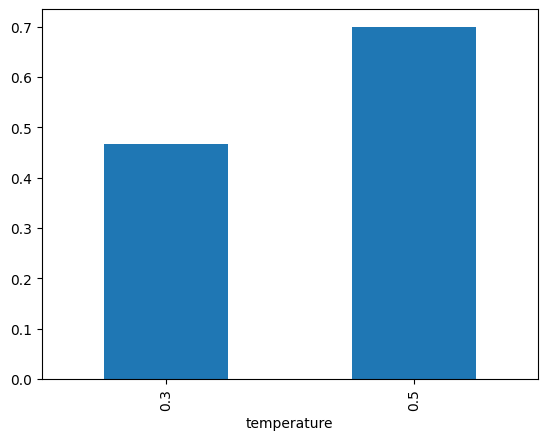

In [45]:
messages = run_agent("Create a plot of the average evaluation score for each temperature setting for the extract_names use case.")
# Answer: temp 0.3 (0.46 avg score) vs temp 0.5 (0.7 avg score). And draws a plot

# Conclusion

This notebook demonstrates how we can implement an agentic RAG system with tool use.

We covered the following use cases:
1. Tool routing
2. Parallel tool use
3. Multi-step tool use
4. Self-correction
5. Structured queries
6. Structured data queries
7. Action (plotting charts)